In [7]:
# Install dependencies if needed
try:
    import vectorbt as vbt
    import yfinance as yf
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
except ImportError:
    import sys
    import subprocess
    subprocess.run([
        sys.executable, "-m", "pip", "install", "-q", 
        "vectorbt", "yfinance", "pandas", "numpy", "matplotlib", "seaborn"
    ], check=False)
    import vectorbt as vbt
    import yfinance as yf
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

print("✅ Dependencies loaded")


✅ Dependencies loaded


In [8]:
# Import strategy combination modules
import sys
from pathlib import Path

# Add project root to Python path so we can import src
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import importlib
import src.strategies.strategies as _lib_strategies
import src.backtesting.data_loader as _lib_data_loader
import src.backtesting.legs as _lib_legs  # Explicitly import legs module
import src.backtesting.strategy_combiner as _lib_strategy_combiner
import src.backtesting.portfolio_combo as _lib_portfolio_combo
import src.backtesting.performance_analyzer as _lib_performance_analyzer

# Reload modules to pick up any changes
# IMPORTANT: Reload legs BEFORE strategy_combiner so the updated backtest_leg signature is picked up
importlib.reload(_lib_strategies)
importlib.reload(_lib_data_loader)
importlib.reload(_lib_legs)  # Explicitly reload legs module to pick up backtest_leg changes
importlib.reload(_lib_strategy_combiner)  # This will re-import backtest_leg from the reloaded legs module
importlib.reload(_lib_portfolio_combo)
importlib.reload(_lib_performance_analyzer)

from src.strategies.strategies import STRATEGIES, register_strategy
from src.backtesting.strategy_combiner import StrategyCombiner, StrategyConfig
from src.backtesting.performance_analyzer import PerformanceAnalyzer

# Verify backtest_leg has the updated signature
import inspect
from src.backtesting.legs import backtest_leg
sig = inspect.signature(backtest_leg)
has_safe_asset = 'safe_asset_prices' in sig.parameters
print("✅ Strategy combination modules imported")
print(f"Available strategies: {list(STRATEGIES.keys())}")
if has_safe_asset:
    print("✅ backtest_leg has safe_asset support enabled")
else:
    print("⚠️ Warning: backtest_leg does not have safe_asset support - may need kernel restart")


✅ Strategy combination modules imported
Available strategies: ['sma_cross', 'tqqq_3ema_macdv_aroon', 'btc_3ema_macdv_aroon', '3ema_macdv', '3ema_macd_rsi', 'macd_rsi', 'macdv', 'rsi', 'rsi_aroon', 'aroon']
✅ backtest_leg has safe_asset support enabled


In [9]:
# Configuration
CONFIG = {
    "start_date": "2018-01-01",
    "end_date": None,  # None means up to latest available
    "initial_capital": 100_000.0,
    "fees": 0.0005,  # 0.05% per trade
    "slippage": 0.0005,  # 0.05% slippage
    "risk_free_rate": 0.0,
    "rebalance_freq": 'Q',  # Optional: 'D' (daily), 'W' (weekly), 'M' (monthly), 'Q' (quarterly), 'Y' or 'A' (yearly), None = no rebalancing
    "train_split": 0.6,  # ratio in (0,1) for train portion length
    "safe_asset": 'GLD',  # Optional safe asset ticker (e.g., 'TLT', 'GLD', 'SHY'). When strategies have sell signals, hold this instead of cash. Set to None to use cash.
}

# Define strategies to combine
# Each strategy gets a weight (must sum to 1.0)
STRATEGIES_CONFIG = [
    StrategyConfig(
        id="tqqq_ensemble",
        symbol="TQQQ",
        strategy_name="tqqq_3ema_macdv_aroon",
        params={
            "ema1": 12,
            "ema2": 89,
            "ema3": 125,
            "macd_fast": 25,
            "macd_slow": 30,
            "macd_signal": 85,
            "volume_threshold": 0.0,
            "aroon_length": 66,
        },
        weight=0.5,  # 75% allocation to TQQQ strategy
    ),
    StrategyConfig(
        id="btc_ensemble",
        symbol="BTC-USD",
        strategy_name="3ema_macdv",
        params={
            "ema1": 10,
            "ema2": 64,
            "ema3": 126,
            "macd_fast": 32,
            "macd_slow": 40,
            "macd_signal": 94,
        },
        weight=0.5,  # 75% allocation to TQQQ strategy
    ),
]

# Validate weights sum to 1.0
total_weight = sum(s.weight for s in STRATEGIES_CONFIG)
print(f"Total strategy weights: {total_weight:.4f}")
if abs(total_weight - 1.0) > 1e-6:
    print(f"⚠️ Warning: Weights sum to {total_weight}, not 1.0")

print(f"\n✅ Configured {len(STRATEGIES_CONFIG)} strategy(ies)")


Total strategy weights: 1.0000

✅ Configured 2 strategy(ies)


In [10]:
# Initialize the strategy combiner
# align_to_symbol='TQQQ' ensures BTC (24/7 market) data is aligned to TQQQ trading days
combiner = StrategyCombiner(
    strategies=STRATEGIES_CONFIG,
    initial_capital=CONFIG["initial_capital"],
    fees=CONFIG["fees"],
    slippage=CONFIG["slippage"],
    start_date=CONFIG["start_date"],
    end_date=CONFIG["end_date"],
    align_to_symbol='TQQQ',  # Align all data to TQQQ trading days (important for BTC 24/7 market)
    rebalance_freq=CONFIG["rebalance_freq"],  # Optional periodic rebalancing
    safe_asset=CONFIG["safe_asset"]  # Optional safe asset to hold instead of cash when strategies are out
)

if CONFIG["safe_asset"]:
    print(f"✅ StrategyCombiner initialized (with safe asset: {CONFIG['safe_asset']})")
else:
    print("✅ StrategyCombiner initialized (cash when strategies are out)")


✅ StrategyCombiner initialized (with safe asset: GLD)


In [11]:
# Load data first to determine split point
combiner.load_data()

# Calculate split point for train/validation
if combiner.data is not None:
    # Get the first symbol's data to determine date range
    first_symbol = list(combiner.data.keys())[0]
    all_dates = combiner.data[first_symbol].index
    split_idx = int(len(all_dates) * CONFIG["train_split"])
    train_end_date = all_dates[split_idx-1]
    val_start_date = all_dates[split_idx]
    
    print(f"\n📅 Data Split:")
    print(f"  Training Period: {all_dates[0].date()} → {train_end_date.date()} ({split_idx} days)")
    print(f"  Validation Period: {val_start_date.date()} → {all_dates[-1].date()} ({len(all_dates) - split_idx} days)")
    print(f"  Split Ratio: {CONFIG['train_split']:.0%} / {1-CONFIG['train_split']:.0%}\n")
    
    # Create separate combiners for train and validation
    train_combiner = StrategyCombiner(
        strategies=STRATEGIES_CONFIG,
        initial_capital=CONFIG["initial_capital"],
        fees=CONFIG["fees"],
        slippage=CONFIG["slippage"],
        start_date=CONFIG["start_date"],
        end_date=train_end_date.strftime('%Y-%m-%d'),
        align_to_symbol='TQQQ',
        rebalance_freq=CONFIG["rebalance_freq"],
        safe_asset=CONFIG["safe_asset"]
    )
    
    val_combiner = StrategyCombiner(
        strategies=STRATEGIES_CONFIG,
        initial_capital=CONFIG["initial_capital"],
        fees=CONFIG["fees"],
        slippage=CONFIG["slippage"],
        start_date=val_start_date.strftime('%Y-%m-%d'),
        end_date=CONFIG["end_date"],
        align_to_symbol='TQQQ',
        rebalance_freq=CONFIG["rebalance_freq"],
        safe_asset=CONFIG["safe_asset"]
    )
    
    # Run training backtest
    print("=" * 70)
    print("RUNNING TRAINING SET BACKTEST")
    print("=" * 70)
    train_combiner.run()
    
    # Run validation backtest
    print("\n" + "=" * 70)
    print("RUNNING VALIDATION SET BACKTEST")
    print("=" * 70)
    val_combiner.run()
    
    # Use validation combiner as the main one for full period visualization
    combiner = val_combiner
    
    print("\n✅ Both backtests complete!")
else:
    print("⚠️ Could not load data for splitting")
    combiner.run()
    print("\n✅ Backtest complete!")


Loaded 2863 records for BTC-USD (2018-01-01 to 2025-11-02)
Loaded 1970 records for TQQQ (2018-01-02 to 2025-10-31)
Loaded 1970 records for GLD (2018-01-02 to 2025-10-31)

Aligning all data to TQQQ trading days (1970 days)...
  BTC-USD: 2863 records → 1970 records (aligned to TQQQ)
  GLD: 1970 records → 1970 records (aligned to TQQQ)
✅ Loaded safe asset data: GLD
✅ Loaded data for 2 symbols

📅 Data Split:
  Training Period: 2018-01-02 → 2022-09-12 (1182 days)
  Validation Period: 2022-09-13 → 2025-10-31 (788 days)
  Split Ratio: 60% / 40%

RUNNING TRAINING SET BACKTEST
Loaded 1715 records for BTC-USD (2018-01-01 to 2022-09-11)
Loaded 1181 records for TQQQ (2018-01-02 to 2022-09-09)
Loaded 1181 records for GLD (2018-01-02 to 2022-09-09)

Aligning all data to TQQQ trading days (1181 days)...
  BTC-USD: 1715 records → 1181 records (aligned to TQQQ)
  GLD: 1181 records → 1181 records (aligned to TQQQ)
✅ Loaded safe asset data: GLD
✅ Loaded data for 2 symbols
✅ Backtested tqqq_ensemble (TQQQ

In [12]:
# Create performance analyzers for train and validation
if 'train_combiner' in locals() and 'val_combiner' in locals():
    train_analyzer = PerformanceAnalyzer(train_combiner.combined_portfolio)
    val_analyzer = PerformanceAnalyzer(val_combiner.combined_portfolio)
    
    # Create full period analyzer for combined metrics
    train_returns = train_combiner.get_combined_returns()
    val_returns = val_combiner.get_combined_returns()
    
    # Ensure returns are properly sorted and aligned
    train_returns = train_returns.sort_index()
    val_returns = val_returns.sort_index()
    
    # Combine returns: concatenate train and validation returns
    # When we concatenate and compound returns, it correctly calculates the full period return
    # as if the strategy ran continuously from start to finish
    full_returns = pd.concat([train_returns, val_returns])
    full_returns = full_returns.sort_index()
    
    # Calculate equity curve from combined returns
    full_equity = (1.0 + full_returns.fillna(0.0)).cumprod() * CONFIG["initial_capital"]
    
    # Helper class to combine trades from both periods
    class CombinedTradesPortfolio:
        def __init__(self, train_portfolio, val_portfolio):
            self.train_portfolio = train_portfolio
            self.val_portfolio = val_portfolio
            self._combined_trades = None
        
        @property
        def trades(self):
            if self._combined_trades is None:
                # Combine trades from both periods
                train_trades = None
                val_trades = None
                
                if self.train_portfolio and hasattr(self.train_portfolio, 'trades'):
                    try:
                        train_trades = self.train_portfolio.trades
                    except:
                        pass
                
                if self.val_portfolio and hasattr(self.val_portfolio, 'trades'):
                    try:
                        val_trades = self.val_portfolio.trades
                    except:
                        pass
                
                # Extract trade returns
                train_returns = np.array([])
                val_returns = np.array([])
                
                if train_trades is not None and len(train_trades) > 0:
                    try:
                        if hasattr(train_trades, 'returns'):
                            tr_raw = train_trades.returns.values if hasattr(train_trades.returns, 'values') else np.array(train_trades.returns)
                            train_returns = np.asarray(tr_raw).ravel()
                    except:
                        pass
                
                if val_trades is not None and len(val_trades) > 0:
                    try:
                        if hasattr(val_trades, 'returns'):
                            vr_raw = val_trades.returns.values if hasattr(val_trades.returns, 'values') else np.array(val_trades.returns)
                            val_returns = np.asarray(vr_raw).ravel()
                    except:
                        pass
                
                # Combine into single array
                if len(train_returns) > 0 and len(val_returns) > 0:
                    combined_returns = np.concatenate([train_returns, val_returns])
                elif len(train_returns) > 0:
                    combined_returns = train_returns
                elif len(val_returns) > 0:
                    combined_returns = val_returns
                else:
                    combined_returns = np.array([])
                
                # Create a mock trades object with combined returns
                class CombinedTrades:
                    def __init__(self, returns):
                        self.returns = pd.Series(returns) if len(returns) > 0 else pd.Series(dtype=float)
                        self._len = len(returns)
                    
                    def __len__(self):
                        return self._len
                
                self._combined_trades = CombinedTrades(combined_returns)
            return self._combined_trades
    
    # Create full period analyzer with combined legs
    class FullPeriodAnalyzer(PerformanceAnalyzer):
        def __init__(self, returns, equity, legs_dict, weights, initial_capital):
            class MinimalPortfolio:
                def __init__(self, legs, weights, initial_capital):
                    self.legs = legs
                    self.weights = weights
                    self.initial_capital = initial_capital
            
            self.returns = returns
            self.equity = equity
            self.portfolio = MinimalPortfolio(legs_dict, weights, initial_capital)
    
    # Build combined legs dict for full period
    full_legs = {}
    for leg_id in train_combiner.legs.keys():
        train_leg = train_combiner.legs.get(leg_id)
        val_leg = val_combiner.legs.get(leg_id)
        
        if train_leg and val_leg:
            # Create a leg object that combines both periods
            class FullPeriodLeg:
                def __init__(self, train_leg, val_leg):
                    self.train_leg = train_leg
                    self.val_leg = val_leg
                    self.symbol = val_leg.symbol
                    self.strategy_name = val_leg.strategy_name
                    # Combined data
                    self.equity_curve = pd.concat([train_leg.equity_curve, val_leg.equity_curve])
                    self.returns = pd.concat([train_leg.returns, val_leg.returns])
                    # Keep both portfolio references for trade extraction
                    # For compatibility, set portfolio to a combined trades object
                    self.portfolio = CombinedTradesPortfolio(train_leg.portfolio, val_leg.portfolio)
            
            full_legs[leg_id] = FullPeriodLeg(train_leg, val_leg)
    
    # Create full period analyzer
    full_analyzer = FullPeriodAnalyzer(
        full_returns, 
        full_equity, 
        full_legs,
        val_combiner.combined_portfolio.weights,
        CONFIG["initial_capital"]
    )
    
    # Print comparison with full set metrics
    train_analyzer.print_train_val_comparison(
        train_analyzer, 
        val_analyzer, 
        risk_free_rate=CONFIG["risk_free_rate"],
        full_analyzer=full_analyzer
    )
    
    # Also print individual metrics
    print("\n" + "="*70)
    print("TRAINING SET METRICS (In-Sample)")
    print("="*70)
    train_analyzer.print_metrics_table(risk_free_rate=CONFIG["risk_free_rate"])
    
    print("\n" + "="*70)
    print("VALIDATION SET METRICS (Out-of-Sample)")
    print("="*70)
    val_analyzer.print_metrics_table(risk_free_rate=CONFIG["risk_free_rate"])
    
    # Set main analyzer to validation for later use
    analyzer = val_analyzer
else:
    # Fallback if split didn't work
    analyzer = PerformanceAnalyzer(combiner.combined_portfolio)
    analyzer.print_metrics_table(risk_free_rate=CONFIG["risk_free_rate"])



TRAIN vs VALIDATION vs FULL SET METRICS COMPARISON
METRIC                    TRAINING           VALIDATION         FULL SET           CHANGE            
--------------------------------------------------------------------------------------------------------------

RETURN METRICS:          
Total Return                       1119.73%           611.06%          8573.01%            -45.4%
Annualized Return                    70.52%            87.26%            77.03%             23.7%

RISK METRICS:            
Max Drawdown                        -31.08%           -21.56%           -33.41%             30.6%
Volatility                           31.71%            27.82%            30.21%            -12.3%

RISK-ADJUSTED METRICS:   
Sharpe Ratio                         1.842            2.396            2.043             30.1%
Sortino Ratio                        2.693            4.078            3.134             51.4%

TRADE METRICS:           
Total Trades                            32   

In [13]:
# Print individual strategy leg metrics
analyzer.print_leg_metrics()



INDIVIDUAL STRATEGY PERFORMANCE

tqqq_ensemble (Weight: 50.0%):
  Symbol:              TQQQ
  Strategy:            tqqq_3ema_macdv_aroon
  Total Return:           655.73%
  Sharpe Ratio:              1.70
  Max Drawdown:           -36.88%

btc_ensemble (Weight: 50.0%):
  Symbol:              BTC-USD
  Strategy:            3ema_macdv
  Total Return:           503.90%
  Sharpe Ratio:              1.51
  Max Drawdown:           -36.16%


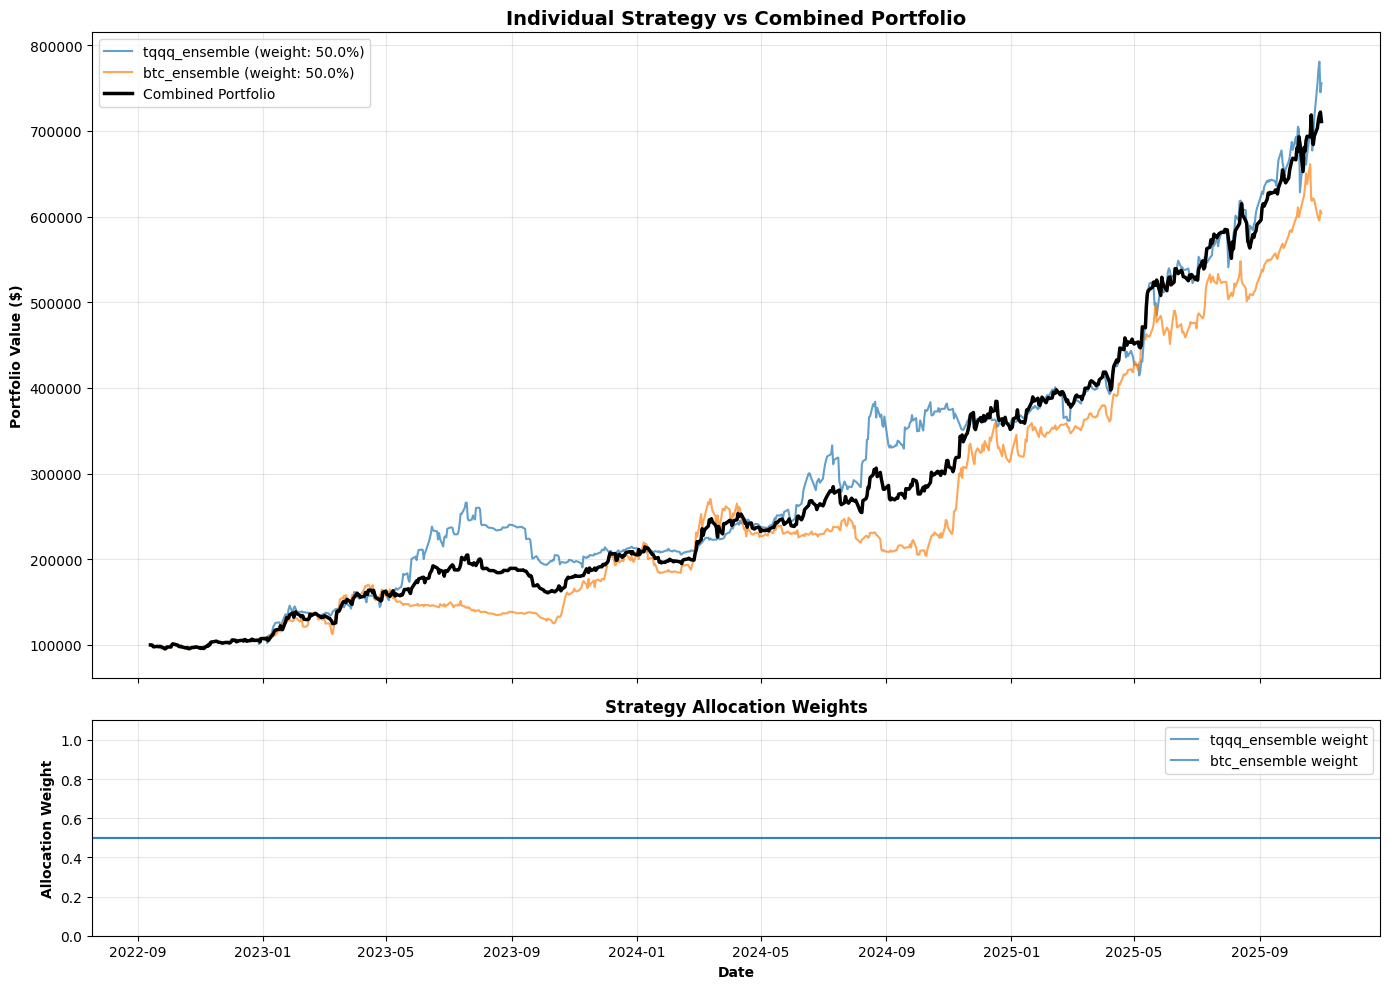

In [14]:
# Plot comparison of individual strategies vs combined portfolio
analyzer.plot_leg_comparison()


C:\Users\harka\OneDrive\Desktop\quant_strat\src\backtesting\performance_analyzer.py:785: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



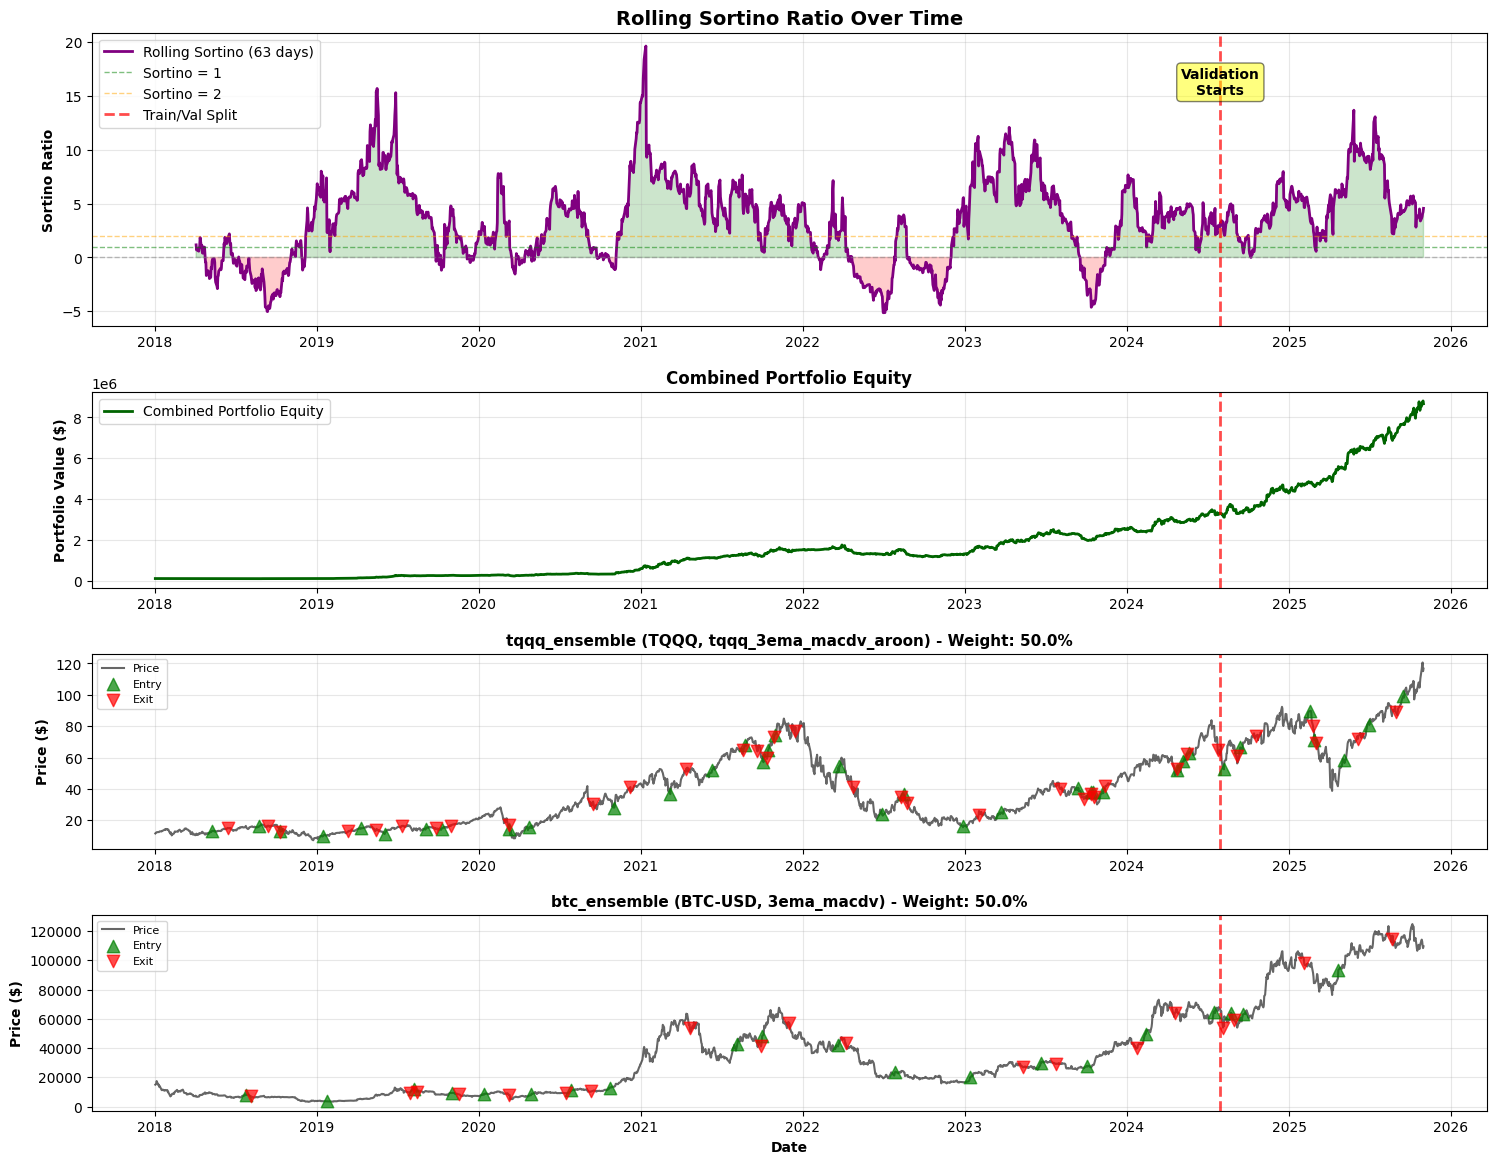


✅ Full period analysis with train/validation split visualization complete!


In [15]:
# Plot rolling Sortino ratio and separate strategy trade entries/exits over full period
# Combine train and validation data for full period visualization

if 'train_combiner' in locals() and 'val_combiner' in locals():
    # Combine returns from both periods for full period analysis
    train_returns = train_combiner.get_combined_returns()
    val_returns = val_combiner.get_combined_returns()
    
    # Combine returns (full period)
    full_returns = pd.concat([train_returns, val_returns])
    full_equity = (1.0 + full_returns).cumprod() * CONFIG["initial_capital"]
    
    # Get train end date
    if 'combiner' in locals() and combiner.data is not None:
        first_symbol = list(combiner.data.keys())[0]
        all_dates = combiner.data[first_symbol].index
        split_idx = int(len(all_dates) * CONFIG["train_split"])
        train_end_date = pd.Timestamp(all_dates[split_idx-1])
    elif len(train_returns) > 0:
        train_end_date = pd.Timestamp(train_returns.index[-1])
    else:
        train_end_date = None
    
    # Create full period analyzer with combined legs
    class FullPeriodAnalyzer(PerformanceAnalyzer):
        def __init__(self, returns, equity, legs_dict, weights):
            class MinimalPortfolio:
                def __init__(self, legs, weights):
                    self.legs = legs
                    self.weights = weights
            
            self.returns = returns
            self.equity = equity
            self.portfolio = MinimalPortfolio(legs_dict, weights)
    
    # Build combined legs dict for full period
    full_legs = {}
    for leg_id in train_combiner.legs.keys():
        train_leg = train_combiner.legs.get(leg_id)
        val_leg = val_combiner.legs.get(leg_id)
        
        if train_leg and val_leg:
            # Create a leg object that combines both periods
            class FullPeriodLeg:
                def __init__(self, train_leg, val_leg):
                    self.train_leg = train_leg
                    self.val_leg = val_leg
                    self.symbol = val_leg.symbol
                    self.strategy_name = val_leg.strategy_name
                    # Combined data
                    self.equity_curve = pd.concat([train_leg.equity_curve, val_leg.equity_curve])
                    self.returns = pd.concat([train_leg.returns, val_leg.returns])
                    # Keep portfolio references for trade extraction
                    self.portfolio = val_leg.portfolio  # For trade order access
            
            full_legs[leg_id] = FullPeriodLeg(train_leg, val_leg)
    
    # Create full period analyzer
    full_analyzer = FullPeriodAnalyzer(
        full_returns, 
        full_equity, 
        full_legs,
        val_combiner.combined_portfolio.weights
    )
    
    # Plot rolling Sortino and trades with train/val split
    full_analyzer.plot_rolling_sortino_and_trades(train_end_date=train_end_date, window=63)
    
    print("\n✅ Full period analysis with train/validation split visualization complete!")
else:
    # Fallback if no split - just plot without split indicator
    if 'analyzer' in locals() and len(combiner.combined_portfolio.legs) > 0:
        analyzer.plot_rolling_sortino_and_trades(window=63)
    else:
        print("⚠️ No legs available for plotting")


In [16]:
# Historical Backtest: 2010 to Training Start
# This tests the strategy on data before the training period

if 'train_combiner' in locals() and 'val_combiner' in locals():
    # Get the training start date from train_combiner (this is when our main backtest starts)
    if train_combiner.data is not None and len(train_combiner.data) > 0:
        first_symbol = list(train_combiner.data.keys())[0]
        train_dates = train_combiner.data[first_symbol].index
        train_start_date = train_dates[0]  # Start of training period
        historical_end_date = train_start_date.strftime('%Y-%m-%d')
        print(f"Historical period will end at: {historical_end_date} (training start)")
    else:
        # Fallback to CONFIG start_date if train_combiner data not available
        historical_end_date = CONFIG["start_date"]
        print(f"Using CONFIG start_date as historical end: {historical_end_date}")
    
    # Create historical combiner (2010 to training start)
    print("=" * 70)
    print("RUNNING HISTORICAL BACKTEST (2010 to Training Start)")
    print("=" * 70)
    
    historical_combiner = StrategyCombiner(
        strategies=STRATEGIES_CONFIG,
        initial_capital=CONFIG["initial_capital"],
        fees=CONFIG["fees"],
        slippage=CONFIG["slippage"],
        start_date="2010-01-01",  # Start from 2010
        end_date=historical_end_date,  # Up to training start
        align_to_symbol='TQQQ',
        rebalance_freq=CONFIG["rebalance_freq"],
        safe_asset=CONFIG["safe_asset"]
    )
    
    # Run historical backtest
    try:
        historical_combiner.run()
        historical_backtest_success = True
    except Exception as e:
        print(f"⚠️ Warning: Historical backtest failed: {e}")
        print("This might be because some symbols (e.g., TQQQ) weren't available in 2010")
        historical_backtest_success = False
        hist_analyzer = None
        hist_combiner = None
    
    if historical_backtest_success:
        # Create performance analyzer for historical period
        historical_analyzer = PerformanceAnalyzer(historical_combiner.combined_portfolio)
        
        print("\n" + "="*70)
        print("HISTORICAL PERIOD METRICS (2010 to Training Start)")
        print("="*70)
        historical_analyzer.print_metrics_table(risk_free_rate=CONFIG["risk_free_rate"])
        
        # Store for later comparison
        hist_analyzer = historical_analyzer
        hist_combiner = historical_combiner
        
        print("\n✅ Historical backtest complete!")
    else:
        hist_analyzer = None
        hist_combiner = None
else:
    print("⚠️ Could not run historical backtest - train/validation combiners not found")
    hist_analyzer = None
    hist_combiner = None


Historical period will end at: 2018-01-02 (training start)
RUNNING HISTORICAL BACKTEST (2010 to Training Start)
Loaded 1203 records for BTC-USD (2014-09-17 to 2018-01-01)
Loaded 1986 records for TQQQ (2010-02-11 to 2017-12-29)
Loaded 2013 records for GLD (2010-01-04 to 2017-12-29)

Aligning all data to TQQQ trading days (1986 days)...
  BTC-USD: 1203 records → 1986 records (aligned to TQQQ)
  GLD: 2013 records → 1986 records (aligned to TQQQ)
✅ Loaded safe asset data: GLD
✅ Loaded data for 2 symbols
✅ Backtested tqqq_ensemble (TQQQ, tqqq_3ema_macdv_aroon) (with safe asset: GLD)
✅ Backtested btc_ensemble (BTC-USD, 3ema_macdv) (with safe asset: GLD)
✅ Combined 2 strategies into portfolio

✅ Strategy combination backtest complete!

HISTORICAL PERIOD METRICS (2010 to Training Start)

📊 Performance Metrics:
  Total Return:         2391.52%
  Annualized Return:      50.38%
  Sharpe Ratio:           1.502
  Sortino Ratio:          2.070
  Max Drawdown:          -25.33%
  Volatility:          

In [17]:
# Comprehensive Comparison: Historical vs Training vs Validation

if 'hist_analyzer' in locals() and hist_analyzer is not None and \
   'train_analyzer' in locals() and 'val_analyzer' in locals():
    
    print("\n" + "="*90)
    print("COMPREHENSIVE METRICS COMPARISON: HISTORICAL vs TRAINING vs VALIDATION")
    print("="*90)
    
    # Get metrics for each period (excluding Full Set)
    metrics = {
        'Historical': hist_analyzer,
        'Training': train_analyzer,
        'Validation': val_analyzer
    }
    
    # Calculate all metrics
    comparison_data = []
    for period_name, analyzer in metrics.items():
        returns = analyzer.returns
        equity = analyzer.equity
        
        # Calculate metrics
        total_return = (equity.iloc[-1] / equity.iloc[0] - 1) * 100
        
        # Annualized return
        years = (returns.index[-1] - returns.index[0]).days / 365.25
        annualized_return = ((equity.iloc[-1] / equity.iloc[0]) ** (1 / years) - 1) * 100 if years > 0 else 0
        
        # Sharpe Ratio
        if len(returns) > 1:
            excess_returns = returns - (CONFIG["risk_free_rate"] / 252)  # Daily risk-free rate
            sharpe = (excess_returns.mean() * 252) / (excess_returns.std() * np.sqrt(252)) if excess_returns.std() > 0 else 0
        else:
            sharpe = 0
        
        # Sortino Ratio
        if len(returns) > 1:
            downside_returns = returns[returns < 0]
            downside_std = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
            sortino = (excess_returns.mean() * 252) / downside_std if downside_std > 0 else 0
        else:
            sortino = 0
        
        # Max Drawdown
        # Note: Max drawdown in full set can be larger than individual periods because:
        # 1. It's measured from the peak across the ENTIRE period (including across period boundaries)
        # 2. If Historical ends at a peak and Training/Val has a drawdown, the full set drawdown
        #    is measured from that historical peak to the training/val trough
        rolling_max = equity.cummax()
        drawdown = (equity - rolling_max) / rolling_max
        max_drawdown = drawdown.min() * 100
        

        
        # Volatility
        volatility = returns.std() * np.sqrt(252) * 100 if len(returns) > 1 else 0
        
        # Trade metrics
        total_trades = 0
        win_rate = 0
        profit_factor = 0
        
        try:
            if hasattr(analyzer.portfolio, 'trades') and analyzer.portfolio.trades is not None:
                trades = analyzer.portfolio.trades
                if len(trades) > 0:
                    total_trades = len(trades)
                    if hasattr(trades, 'returns'):
                        trade_returns = trades.returns.values if hasattr(trades.returns, 'values') else np.array(trades.returns)
                        winning_trades = trade_returns[trade_returns > 0]
                        losing_trades = trade_returns[trade_returns < 0]
                        win_rate = len(winning_trades) / len(trade_returns) * 100 if len(trade_returns) > 0 else 0
                        gross_profit = winning_trades.sum() if len(winning_trades) > 0 else 0
                        gross_loss = abs(losing_trades.sum()) if len(losing_trades) > 0 else 1
                        profit_factor = gross_profit / gross_loss if gross_loss > 0 else 0
        except:
            pass
        
        comparison_data.append({
            'Period': period_name,
            'Total Return (%)': total_return,
            'Annualized Return (%)': annualized_return,
            'Sharpe Ratio': sharpe,
            'Sortino Ratio': sortino,
            'Max Drawdown (%)': max_drawdown,
            'Volatility (%)': volatility,
            'Total Trades': total_trades,
            'Win Rate (%)': win_rate,
            'Profit Factor': profit_factor
        })
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    
    # Print formatted comparison table
    print("\n" + "-"*90)
    print(f"{'METRIC':<25} {'HISTORICAL':<15} {'TRAINING':<15} {'VALIDATION':<15}")
    print("-"*90)
    
    metrics_to_show = [
        ('Total Return (%)', 'Total Return (%)'),
        ('Annualized Return (%)', 'Annualized Return (%)'),
        ('Sharpe Ratio', 'Sharpe Ratio'),
        ('Sortino Ratio', 'Sortino Ratio'),
        ('Max Drawdown (%)', 'Max Drawdown (%)'),
        ('Volatility (%)', 'Volatility (%)'),
        ('Total Trades', 'Total Trades'),
        ('Win Rate (%)', 'Win Rate (%)'),
        ('Profit Factor', 'Profit Factor')
    ]
    
    for metric_display, metric_key in metrics_to_show:
        hist_val = comparison_df[comparison_df['Period'] == 'Historical'][metric_key].values[0] if 'Historical' in comparison_df['Period'].values else 0
        train_val = comparison_df[comparison_df['Period'] == 'Training'][metric_key].values[0] if 'Training' in comparison_df['Period'].values else 0
        val_val = comparison_df[comparison_df['Period'] == 'Validation'][metric_key].values[0] if 'Validation' in comparison_df['Period'].values else 0
        
        print(f"{metric_display:<25} {hist_val:>14.2f} {train_val:>14.2f} {val_val:>14.2f}")
    
    print("-"*90)
    
    # Calculate consistency metrics
    sharpe_values = comparison_df['Sharpe Ratio'].values
    if len(sharpe_values) > 1:
        sharpe_std = np.std(sharpe_values)
        sharpe_mean = np.mean(sharpe_values)
        sharpe_cv = (sharpe_std / sharpe_mean) * 100 if sharpe_mean != 0 else 0
        print(f"\n📊 Sharpe Ratio Consistency (Historical/Train/Val):")
        print(f"   Mean Sharpe: {sharpe_mean:.3f}")
        print(f"   Std Dev: {sharpe_std:.3f}")
        print(f"   Coefficient of Variation: {sharpe_cv:.2f}%")
        if sharpe_cv < 20:
            print(f"   ✅ Low variation - strategy is consistent across periods")
        elif sharpe_cv < 40:
            print(f"   ⚠️ Moderate variation - strategy performance varies somewhat")
        else:
            print(f"   ⚠️ High variation - strategy performance varies significantly")
    
else:
    print("⚠️ Could not create comprehensive comparison - some analyzers are missing")



COMPREHENSIVE METRICS COMPARISON: HISTORICAL vs TRAINING vs VALIDATION

------------------------------------------------------------------------------------------
METRIC                    HISTORICAL      TRAINING        VALIDATION     
------------------------------------------------------------------------------------------
Total Return (%)                 2391.52        1119.73         611.06
Annualized Return (%)              50.39          70.56          87.06
Sharpe Ratio                        1.50           1.84           2.40
Sortino Ratio                       2.07           2.69           4.08
Max Drawdown (%)                  -25.33         -31.08         -21.56
Volatility (%)                     30.18          31.71          27.82
Total Trades                        0.00           0.00           0.00
Win Rate (%)                        0.00           0.00           0.00
Profit Factor                       0.00           0.00           0.00
--------------------------------

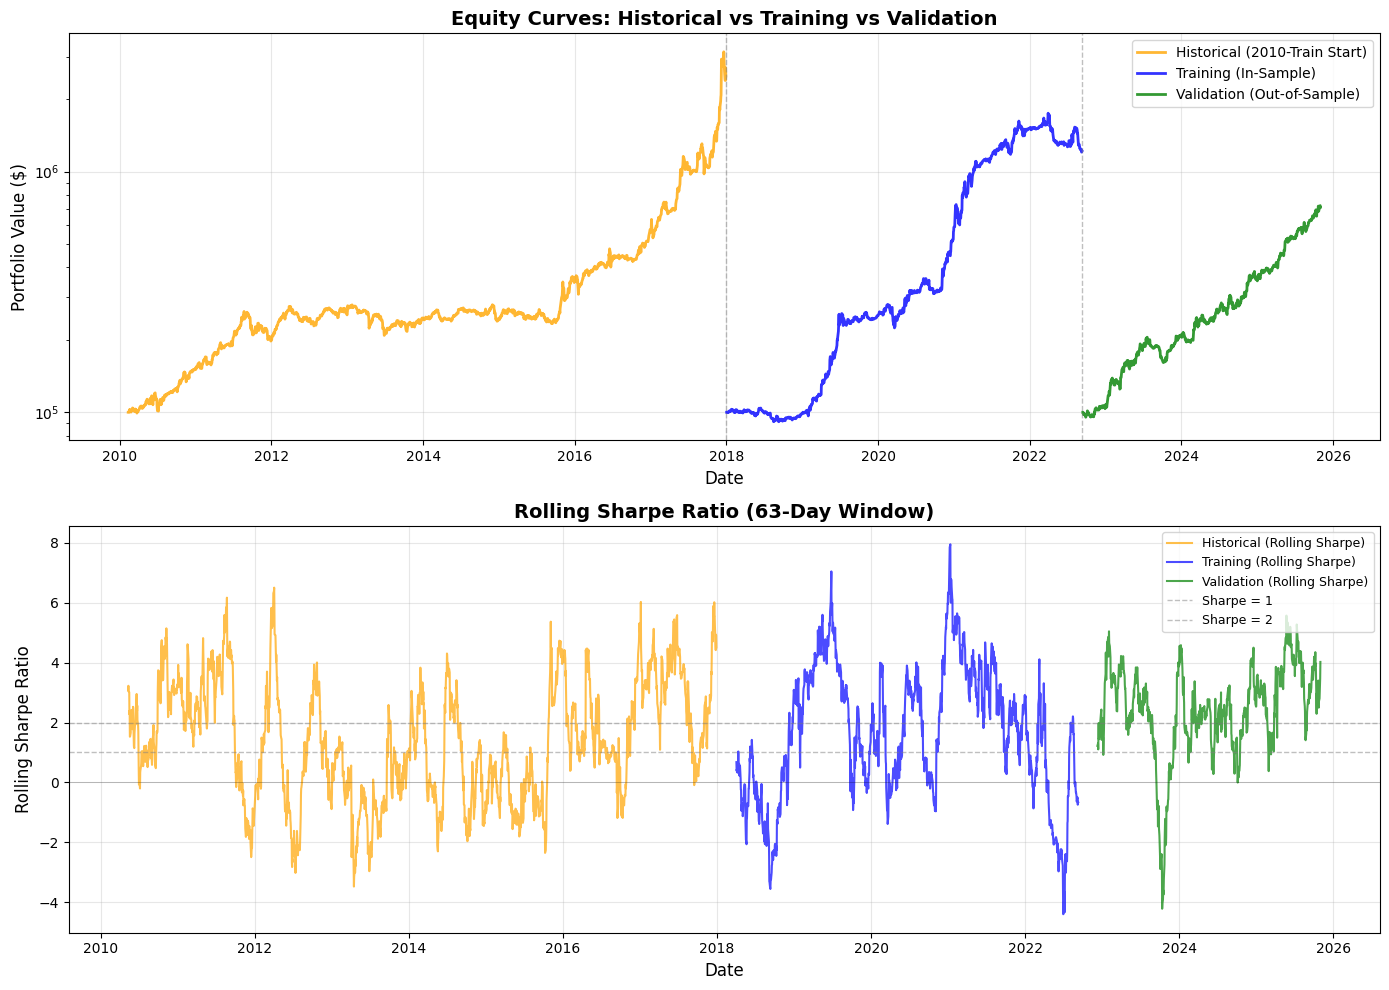


✅ Equity curves and rolling Sharpe comparison plots generated!


In [18]:
# Plot Historical vs Training vs Validation Equity Curves

if 'hist_analyzer' in locals() and hist_analyzer is not None and \
   'train_analyzer' in locals() and 'val_analyzer' in locals():
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Equity curves comparison
    ax1 = axes[0]
    
    # Get equity curves (normalized to start at initial capital)
    hist_equity = hist_combiner.get_combined_equity()
    train_equity = train_combiner.get_combined_equity()
    val_equity = val_combiner.get_combined_equity()
    
    # Plot all equity curves
    ax1.plot(hist_equity.index, hist_equity.values, label='Historical (2010-Train Start)', linewidth=2, alpha=0.8, color='orange')
    ax1.plot(train_equity.index, train_equity.values, label='Training (In-Sample)', linewidth=2, alpha=0.8, color='blue')
    ax1.plot(val_equity.index, val_equity.values, label='Validation (Out-of-Sample)', linewidth=2, alpha=0.8, color='green')
    
    # Add vertical lines to separate periods
    if len(hist_equity) > 0:
        ax1.axvline(x=hist_equity.index[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
    if len(train_equity) > 0:
        ax1.axvline(x=train_equity.index[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
    
    ax1.set_title('Equity Curves: Historical vs Training vs Validation', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')  # Use log scale for better visualization
    
    # Plot 2: Rolling Sharpe Ratio comparison
    ax2 = axes[1]
    
    window = 63  # 3-month rolling window
    
    # Calculate rolling Sharpe for each period
    for name, returns, color in [
        ('Historical', hist_analyzer.returns, 'orange'),
        ('Training', train_analyzer.returns, 'blue'),
        ('Validation', val_analyzer.returns, 'green')
    ]:
        if len(returns) >= window:
            rolling_mean = returns.rolling(window=window).mean() * 252
            rolling_std = returns.rolling(window=window).std() * np.sqrt(252)
            rolling_sharpe = rolling_mean / rolling_std
            rolling_sharpe = rolling_sharpe.replace([np.inf, -np.inf], np.nan).dropna()
            
            ax2.plot(rolling_sharpe.index, rolling_sharpe.values, label=f'{name} (Rolling Sharpe)', 
                    linewidth=1.5, alpha=0.7, color=color)
    
    # Add horizontal line at Sharpe = 0
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
    ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5, linewidth=1, label='Sharpe = 1')
    ax2.axhline(y=2, color='gray', linestyle='--', alpha=0.5, linewidth=1, label='Sharpe = 2')
    
    ax2.set_title(f'Rolling Sharpe Ratio ({window}-Day Window)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Rolling Sharpe Ratio', fontsize=12)
    ax2.legend(loc='best', fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Equity curves and rolling Sharpe comparison plots generated!")
else:
    print("⚠️ Could not create equity curve comparison - historical analyzer not available")


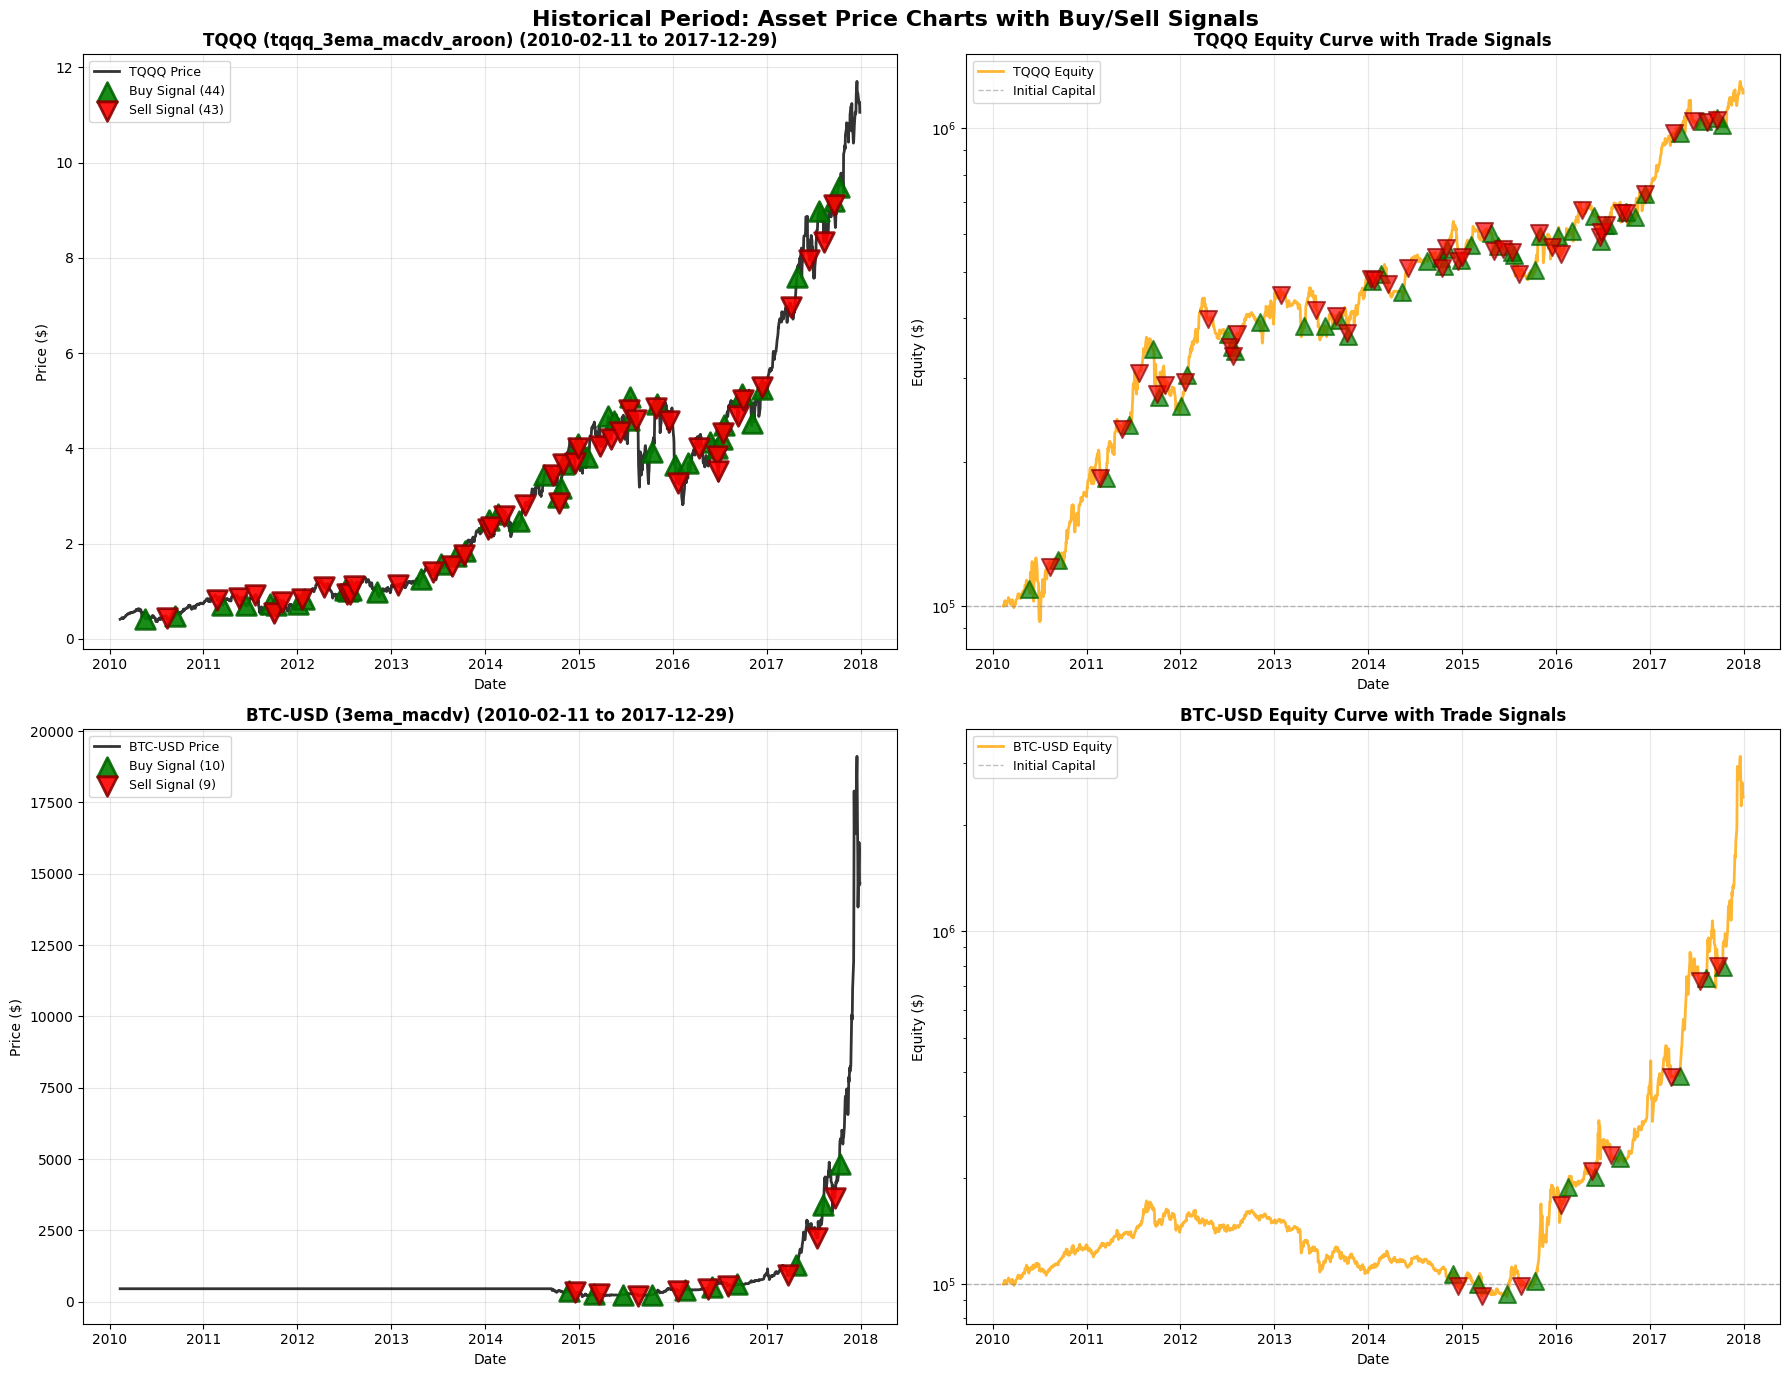


✅ Historical period visualization complete!
   Assets shown: 2
   TQQQ: 48 buy signals, 47 sell signals
   BTC-USD: 10 buy signals, 9 sell signals


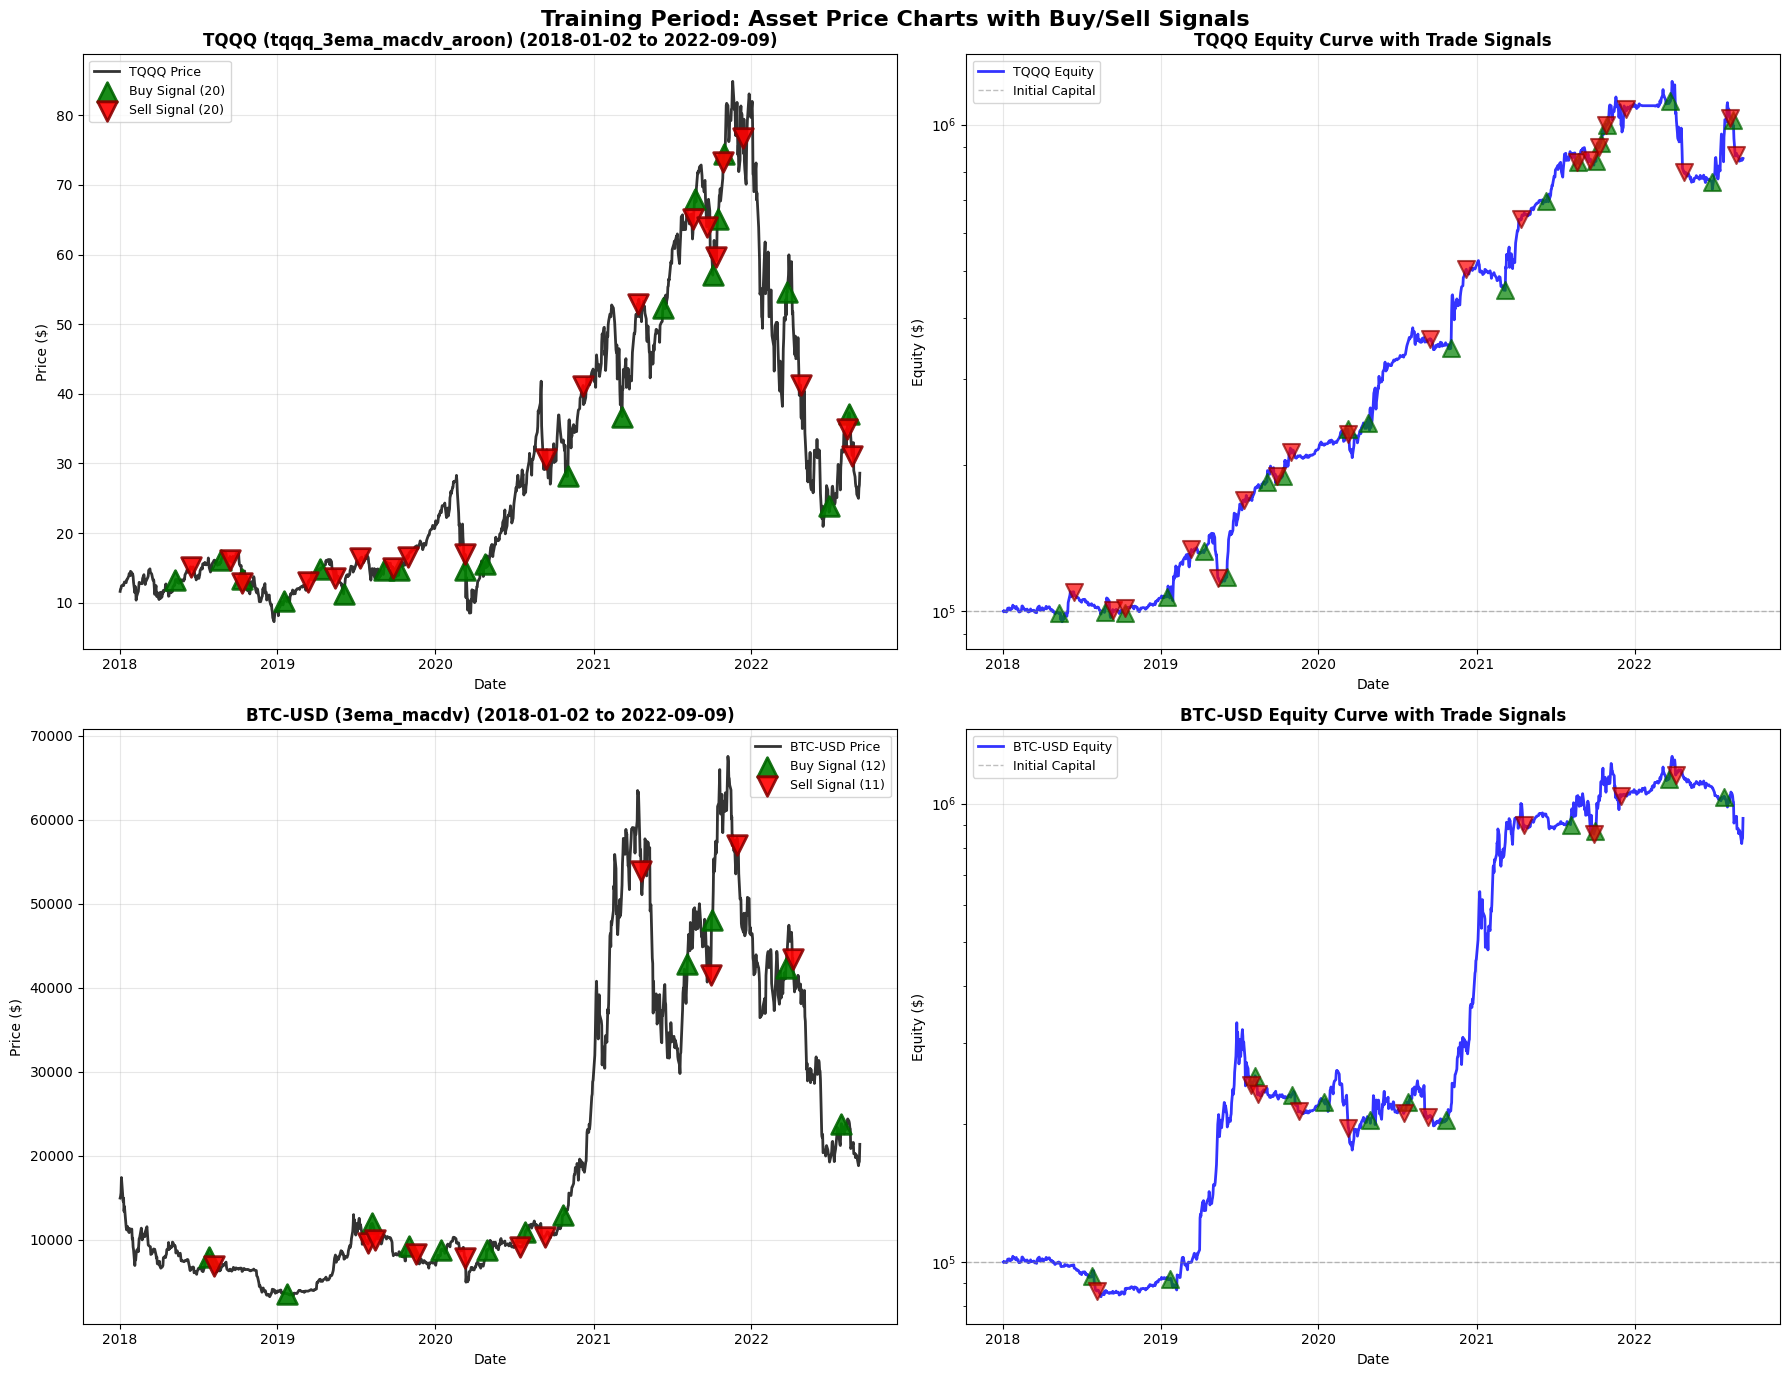


✅ Training period visualization complete!
   Assets shown: 2
   TQQQ: 21 buy signals, 21 sell signals
   BTC-USD: 12 buy signals, 11 sell signals


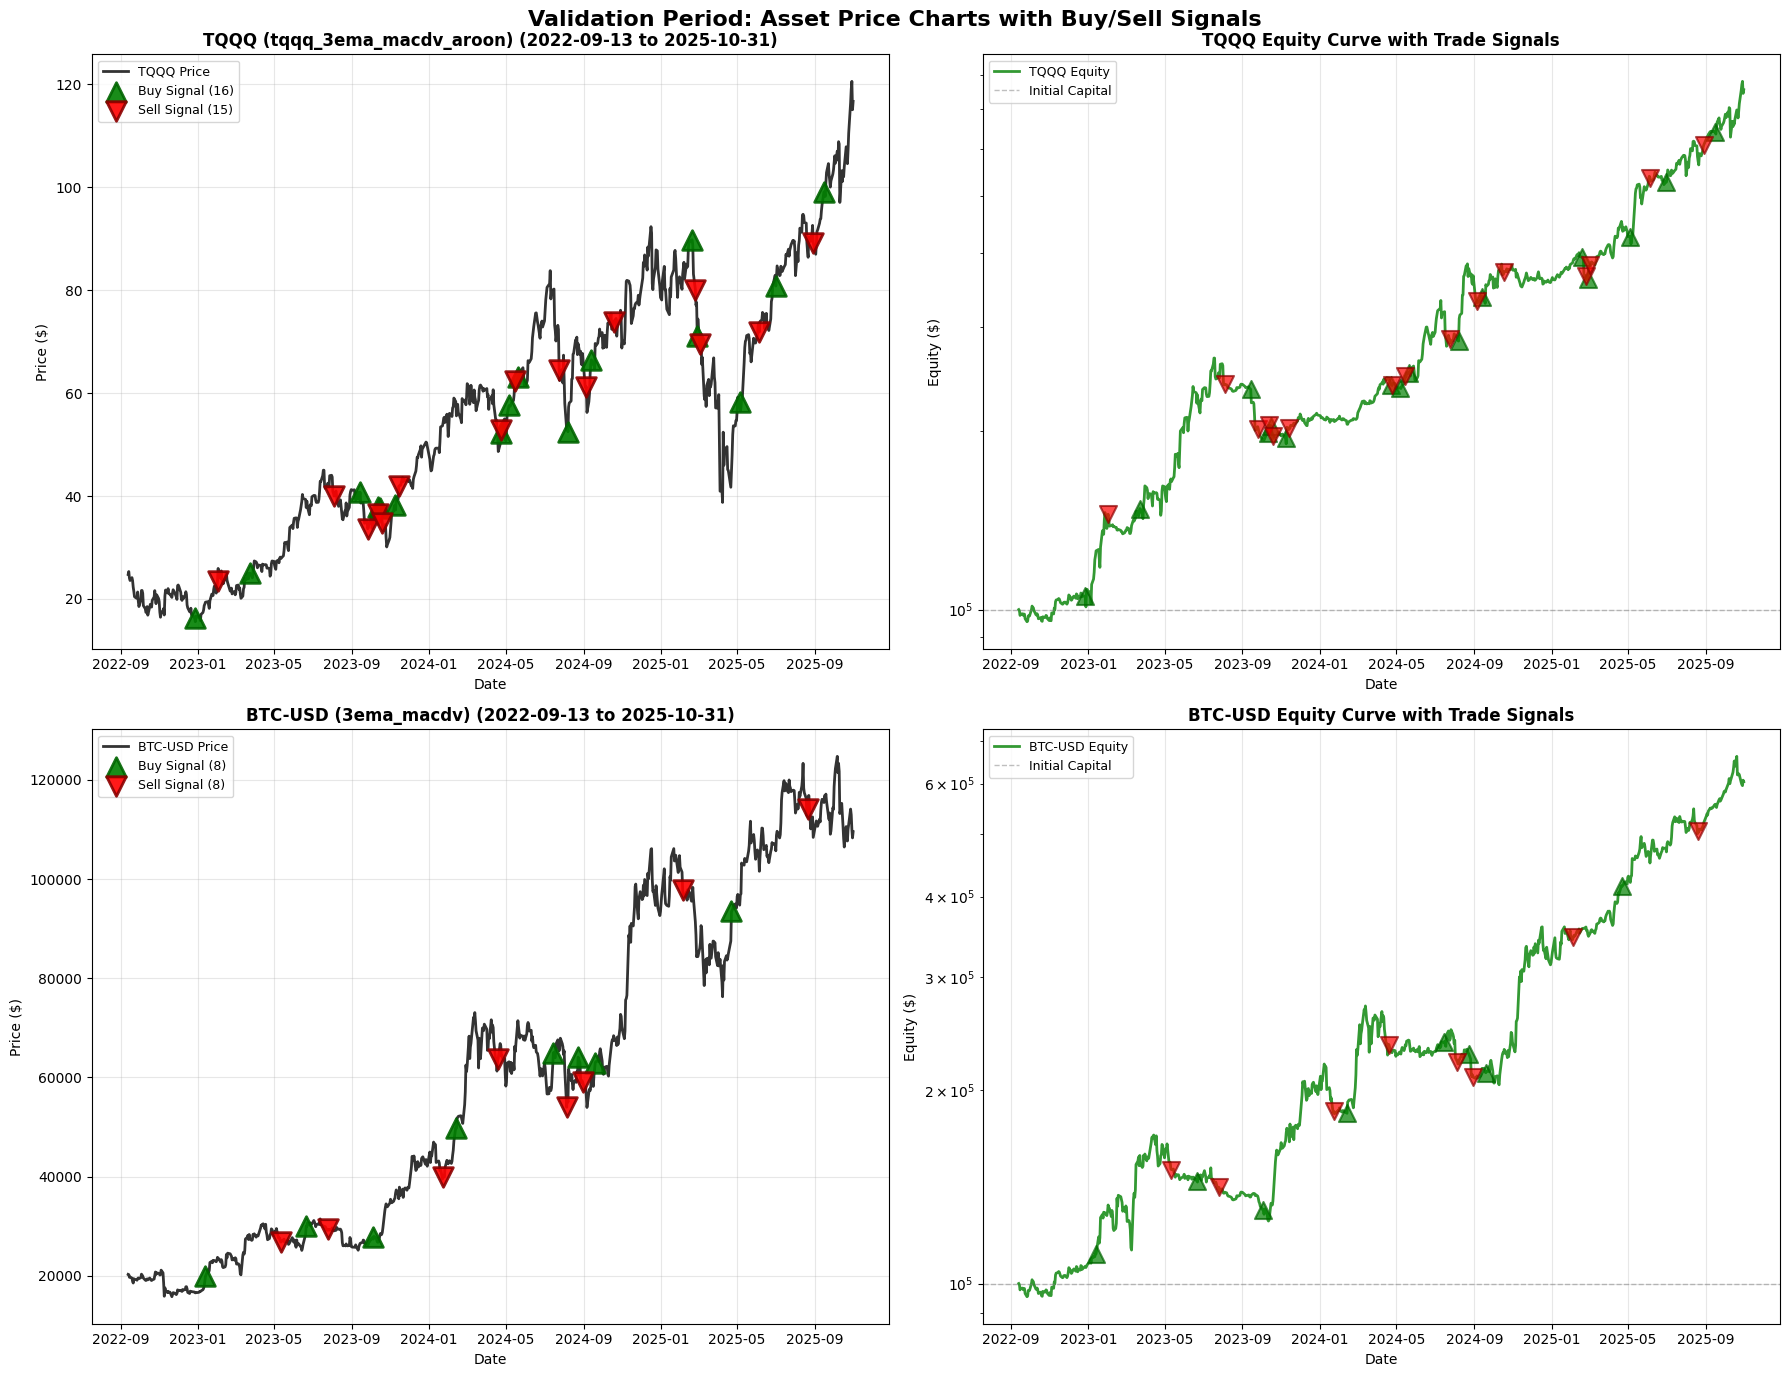


✅ Validation period visualization complete!
   Assets shown: 2
   TQQQ: 16 buy signals, 15 sell signals
   BTC-USD: 8 buy signals, 8 sell signals


In [19]:
# Detailed graphs with buy/sell signals for each asset per period

if 'hist_combiner' in locals() and 'train_combiner' in locals() and 'val_combiner' in locals():
    
    # Get the actual date boundaries to ensure proper filtering
    train_start_date = None
    train_end_date = None
    val_start_date = None
    
    if train_combiner.data is not None and len(train_combiner.data) > 0:
        first_symbol = list(train_combiner.data.keys())[0]
        train_dates = train_combiner.data[first_symbol].index
        train_start_date = train_dates[0] if len(train_dates) > 0 else None
        train_end_date = train_dates[-1] if len(train_dates) > 0 else None
    
    if val_combiner.data is not None and len(val_combiner.data) > 0:
        first_symbol = list(val_combiner.data.keys())[0]
        val_dates = val_combiner.data[first_symbol].index
        val_start_date = val_dates[0] if len(val_dates) > 0 else None
    
    periods = [
        ('Historical', hist_combiner, 'orange', None, train_start_date),
        ('Training', train_combiner, 'blue', train_start_date, train_end_date),
        ('Validation', val_combiner, 'green', val_start_date, None)
    ]
    
    for period_name, combiner, period_color, period_start, period_end in periods:
        if combiner.legs is None or len(combiner.legs) == 0:
            print(f"⚠️ {period_name} period: No legs available")
            continue
        
        # Create a figure with subplots for each asset/strategy
        num_legs = len(combiner.legs)
        fig, axes = plt.subplots(num_legs, 2, figsize=(18, 7 * num_legs))
        if num_legs == 1:
            axes = axes.reshape(1, -1)
        
        fig.suptitle(f'{period_name} Period: Asset Price Charts with Buy/Sell Signals', 
                     fontsize=16, fontweight='bold')
        
        for idx, (leg_id, leg_result) in enumerate(combiner.legs.items()):
            # Left subplot: Price chart with signals
            ax1 = axes[idx, 0]
            
            # Get price data and filter to period boundaries
            prices = leg_result.close
            symbol = leg_result.symbol
            
            # Filter prices to period boundaries if specified
            if period_start is not None:
                prices = prices[prices.index >= period_start]
            if period_end is not None:
                prices = prices[prices.index <= period_end]
            
            # Plot price
            ax1.plot(prices.index, prices.values, label=f'{symbol} Price', 
                    linewidth=2, color='black', alpha=0.8)
            
            # Get entry/exit signals - try multiple methods
            entry_dates_list = []
            entry_prices_list = []
            exit_dates_list = []
            exit_prices_list = []
            
            # Method 1: Try to get signals from portfolio orders (most accurate)
            if leg_result.portfolio is not None:
                try:
                    orders = leg_result.portfolio.orders.records_readable
                    if len(orders) > 0:
                        buy_orders = orders[orders['Side'] == 'Buy']
                        sell_orders = orders[orders['Side'] == 'Sell']
                        
                        if len(buy_orders) > 0:
                            entry_dates_temp = pd.to_datetime(buy_orders['Timestamp'])
                            entry_prices_temp = buy_orders['Price'].values
                            
                            # Filter entry signals to period boundaries
                            if period_start is not None:
                                mask = entry_dates_temp >= pd.Timestamp(period_start)
                                entry_dates_temp = entry_dates_temp[mask]
                                entry_prices_temp = entry_prices_temp[mask]
                            if period_end is not None:
                                mask = entry_dates_temp <= pd.Timestamp(period_end)
                                entry_dates_temp = entry_dates_temp[mask]
                                entry_prices_temp = entry_prices_temp[mask]
                            
                            entry_dates_list.extend(entry_dates_temp)
                            entry_prices_list.extend(entry_prices_temp)
                        
                        if len(sell_orders) > 0:
                            exit_dates_temp = pd.to_datetime(sell_orders['Timestamp'])
                            exit_prices_temp = sell_orders['Price'].values
                            
                            # Filter exit signals to period boundaries
                            if period_start is not None:
                                mask = exit_dates_temp >= pd.Timestamp(period_start)
                                exit_dates_temp = exit_dates_temp[mask]
                                exit_prices_temp = exit_prices_temp[mask]
                            if period_end is not None:
                                mask = exit_dates_temp <= pd.Timestamp(period_end)
                                exit_dates_temp = exit_dates_temp[mask]
                                exit_prices_temp = exit_prices_temp[mask]
                            
                            exit_dates_list.extend(exit_dates_temp)
                            exit_prices_list.extend(exit_prices_temp)
                except Exception as e:
                    pass
            
            # Method 2: Use exposure to infer signals (fallback)
            if len(entry_dates_list) == 0 and len(exit_dates_list) == 0:
                exposure = leg_result.exposure
                
                # Filter exposure to period boundaries first
                if period_start is not None:
                    exposure = exposure[exposure.index >= period_start]
                if period_end is not None:
                    exposure = exposure[exposure.index <= period_end]
                
                # Align exposure with prices
                exposure = exposure.reindex(prices.index, method='ffill').fillna(0)
                
                exposure_prev = exposure.shift(1).fillna(0)
                entries = (exposure > exposure_prev) & (exposure > 0)
                exits = (exposure < exposure_prev) & (exposure == 0)
                
                if entries.any():
                    entry_dates_list = prices.index[entries].tolist()
                    entry_prices_list = prices[entries].values.tolist()
                
                if exits.any():
                    exit_dates_list = prices.index[exits].tolist()
                    exit_prices_list = prices[exits].values.tolist()
            
            # Plot buy signals
            if len(entry_dates_list) > 0:
                entry_dates_final = pd.to_datetime(entry_dates_list) if not isinstance(entry_dates_list[0], pd.Timestamp) else entry_dates_list
                ax1.scatter(entry_dates_final, entry_prices_list, marker='^', color='green', 
                           s=200, alpha=0.9, label=f'Buy Signal ({len(entry_dates_list)})', 
                           zorder=5, edgecolors='darkgreen', linewidths=2)
            
            # Plot sell signals
            if len(exit_dates_list) > 0:
                exit_dates_final = pd.to_datetime(exit_dates_list) if not isinstance(exit_dates_list[0], pd.Timestamp) else exit_dates_list
                ax1.scatter(exit_dates_final, exit_prices_list, marker='v', color='red', 
                           s=200, alpha=0.9, label=f'Sell Signal ({len(exit_dates_list)})', 
                           zorder=5, edgecolors='darkred', linewidths=2)
            
            # Add period date range to title
            period_str = ""
            if len(prices) > 0:
                period_str = f" ({prices.index[0].strftime('%Y-%m-%d')} to {prices.index[-1].strftime('%Y-%m-%d')})"
            
            ax1.set_title(f'{symbol} ({leg_result.strategy_name}){period_str}', fontsize=12, fontweight='bold')
            ax1.set_xlabel('Date', fontsize=10)
            ax1.set_ylabel('Price ($)', fontsize=10)
            ax1.legend(loc='best', fontsize=9)
            ax1.grid(True, alpha=0.3)
            
            # Right subplot: Equity curve with signals
            ax2 = axes[idx, 1]
            equity = leg_result.equity_curve
            
            # Filter equity to period boundaries if specified
            if period_start is not None:
                equity = equity[equity.index >= period_start]
            if period_end is not None:
                equity = equity[equity.index <= period_end]
            
            ax2.plot(equity.index, equity.values, label=f'{symbol} Equity', 
                    linewidth=2, color=period_color, alpha=0.8)
            
            # Mark entry/exit points on equity curve
            if len(entry_dates_list) > 0:
                entry_dates_final = pd.to_datetime(entry_dates_list) if not isinstance(entry_dates_list[0], pd.Timestamp) else entry_dates_list
                entry_equity = equity.reindex(entry_dates_final, method='ffill')
                ax2.scatter(entry_equity.index, entry_equity.values, marker='^', color='green', 
                           s=150, alpha=0.7, zorder=5, edgecolors='darkgreen', linewidths=1.5)
            
            if len(exit_dates_list) > 0:
                exit_dates_final = pd.to_datetime(exit_dates_list) if not isinstance(exit_dates_list[0], pd.Timestamp) else exit_dates_list
                exit_equity = equity.reindex(exit_dates_final, method='ffill')
                ax2.scatter(exit_equity.index, exit_equity.values, marker='v', color='red', 
                           s=150, alpha=0.7, zorder=5, edgecolors='darkred', linewidths=1.5)
            
            ax2.axhline(y=CONFIG["initial_capital"], color='gray', linestyle='--', alpha=0.5, linewidth=1, label='Initial Capital')
            ax2.set_title(f'{symbol} Equity Curve with Trade Signals', fontsize=12, fontweight='bold')
            ax2.set_xlabel('Date', fontsize=10)
            ax2.set_ylabel('Equity ($)', fontsize=10)
            ax2.legend(loc='best', fontsize=9)
            ax2.grid(True, alpha=0.3)
            ax2.set_yscale('log')  # Use log scale for better visualization
        
        plt.tight_layout()
        plt.show()
        
        # Print signal summary for this period
        print(f"\n✅ {period_name} period visualization complete!")
        print(f"   Assets shown: {num_legs}")
        for leg_id, leg_result in combiner.legs.items():
            exposure = leg_result.exposure
            if period_start is not None:
                exposure = exposure[exposure.index >= period_start]
            if period_end is not None:
                exposure = exposure[exposure.index <= period_end]
            exposure_prev = exposure.shift(1).fillna(0)
            num_buys = ((exposure > exposure_prev) & (exposure > 0)).sum()
            num_sells = ((exposure < exposure_prev) & (exposure == 0)).sum()
            print(f"   {leg_result.symbol}: {num_buys} buy signals, {num_sells} sell signals")
    
else:
    print("⚠️ Could not create detailed signal graphs - combiners not available")
